# Connect to google account

In [572]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [573]:
!pip install category_encoders

In [574]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용
from datetime import datetime, timedelta
from tqdm.auto import tqdm
import category_encoders as ce

In [575]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/Playdata/Competitions/ML/Dacon/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [576]:
args.submission_path = args.default_path + "result/submission_20231110.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_20231110.json" # 결과 저장 json

In [577]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    #recall = np.mean(individual_recalls)
    recall = max(individual_recalls)
    return recall

# File Load

In [578]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화


In [579]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()

# 탐색

### merged_recruitment 생성

In [580]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [581]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


### merged_recruitment 탐색 & drop

In [582]:
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


In [583]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   address_seq2       100 non-null    float64
 3   address_seq3       9 non-null      float64
 4   career_end         6695 non-null   int64  
 5   career_start       6695 non-null   int64  
 6   check_box_keyword  6695 non-null   object 
 7   education          6695 non-null   int64  
 8   major_task         6695 non-null   int64  
 9   qualifications     6695 non-null   int64  
 10  text_keyword       707 non-null    object 
 11  company_type_seq   2377 non-null   float64
 12  supply_kind        2377 non-null   float64
 13  employee           2377 non-null   float64
dtypes: float64(6), int64(5), object(3)
memory usage: 784.6+ KB


In [584]:
merged_recruitment.describe()

,address_seq1,address_seq2,address_seq3,career_end,career_start,education,major_task,qualifications,company_type_seq,supply_kind,employee
count,6694.000000,100.000000,9.000000,6695.0,6695.0,6695.000000,6695.000000,6695.000000,2377.000000,2377.000000,2377.000000
mean,3.103675,7.900000,16.555556,0.0,0.0,3.081703,2.277521,1.317401,2.944468,344.090029,217.696676
std,0.955459,7.399836,6.424778,0.0,0.0,0.753074,1.242267,0.477852,1.739406,131.232212,331.153073
min,1.000000,1.000000,3.000000,0.0,0.0,2.000000,1.000000,0.000000,2.000000,100.000000,0.000000
25%,3.000000,1.000000,18.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,41.000000
50%,3.000000,5.000000,20.000000,0.0,0.0,3.000000,2.000000,1.000000,2.000000,402.000000,145.000000
75%,3.000000,14.000000,20.000000,0.0,0.0,4.000000,2.000000,2.000000,4.000000,402.000000,300.000000
max,20.000000,20.000000,20.000000,0.0,0.0,6.000000,10.000000,2.000000,9.000000,605.000000,12223.000000


In [585]:
(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
career_end           0.000000
career_start         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
address_seq1         0.000149
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
address_seq2         0.985063
address_seq3         0.998656
dtype: float64

- merged_recruitment 상관관계

<ipython-input-586-f7ff05f002b4>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_recruitment.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')


<Axes: >

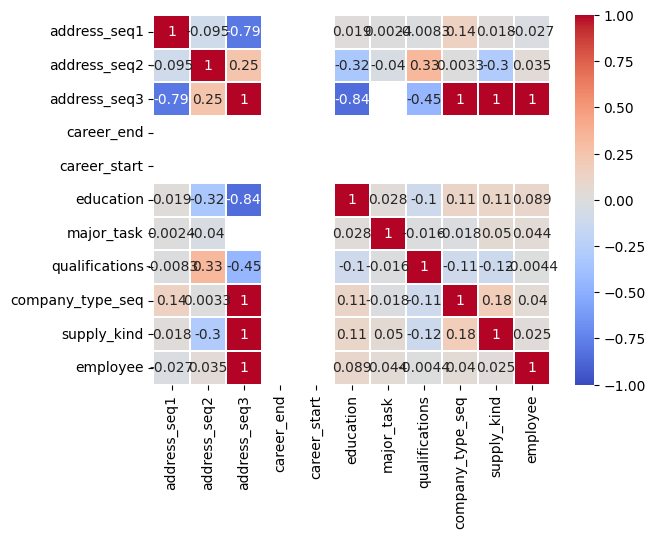

In [586]:
sns.heatmap(merged_recruitment.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

<Axes: >

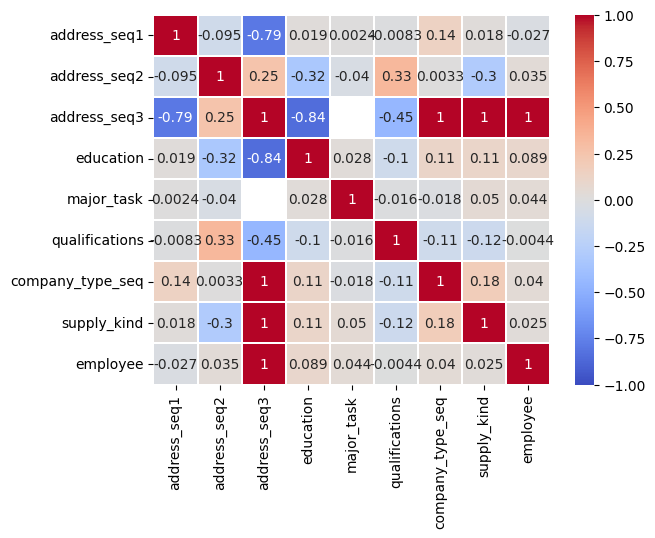

In [587]:
col = merged_recruitment[["address_seq1", "address_seq2", "address_seq3", "education", "major_task", "qualifications", "company_type_seq", "supply_kind", "employee"]]
sns.heatmap(col.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

- 결측치 높은 컬럼 제거

In [588]:
merged_recruitment_drop_col = ['career_start', 'career_end', "address_seq2", "address_seq3"]
merged_recruitment = merged_recruitment.drop(merged_recruitment_drop_col, axis=1)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   recruitment_seq    6695 non-null   object 
 1   address_seq1       6694 non-null   float64
 2   check_box_keyword  6695 non-null   object 
 3   education          6695 non-null   int64  
 4   major_task         6695 non-null   int64  
 5   qualifications     6695 non-null   int64  
 6   text_keyword       707 non-null    object 
 7   company_type_seq   2377 non-null   float64
 8   supply_kind        2377 non-null   float64
 9   employee           2377 non-null   float64
dtypes: float64(4), int64(3), object(3)
memory usage: 575.4+ KB


- company_type_seq, supply_kind, employee값이 있는 것만 추리고 상관관계 확인

In [589]:
erase_df = merged_recruitment.dropna(subset = ["company_type_seq", "supply_kind", "employee"])
erase_df

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
3,R00004,3.0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
8,R00009,3.0,2507;2707,2,8,1,피팅;스타일팀;인턴,2.0,402.0,41.0
10,R00011,3.0,2101;2108;2201;2707,3,7,1,NaN,2.0,100.0,200.0
...,...,...,...,...,...,...,...,...,...,...
6669,R06670,3.0,2201;2204;2205;2707,4,2,1,NaN,5.0,402.0,300.0
6675,R06676,3.0,2507,3,2,1,NaN,2.0,402.0,11.0
6676,R06677,3.0,2101;2507;2707,4,2,1,NaN,9.0,402.0,20.0
6687,R06688,3.0,2507;2204;2201,3,2,1,NaN,2.0,402.0,90.0


<ipython-input-590-c067adaefee7>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(erase_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')


<Axes: >

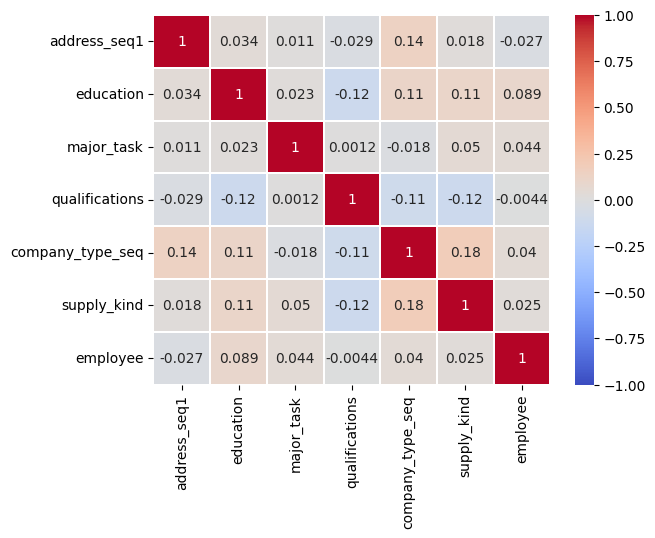

In [590]:
sns.heatmap(erase_df.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

- company_type_seq / supply_kind / employee 는 recruitment 내에서는 상관관계가 유의미하지 않다.

In [591]:
# fill_col = ["address_seq2", "address_seq3", "company_type_seq", "supply_kind", "employee"]

# for col in fill_col:
#   merged_recruitment[col].fillna(0, inplace=True)

# merged_recruitment

- address_seq1은 최빈값으로 채움

In [592]:
addr1_mode = merged_recruitment["address_seq1"].mode().values[0]
merged_recruitment["address_seq1"].fillna(addr1_mode, inplace=True)

(merged_recruitment.isnull().sum() / len(merged_recruitment)).sort_values()

recruitment_seq      0.000000
address_seq1         0.000000
check_box_keyword    0.000000
education            0.000000
major_task           0.000000
qualifications       0.000000
company_type_seq     0.644959
supply_kind          0.644959
employee             0.644959
text_keyword         0.894399
dtype: float64

- check_box_keyword

In [593]:
def extract_main_codes(check_box_keyword):
    # 코드를 세미콜론으로 분리하고, 각 코드의 앞 두 자리를 추출
    if pd.isna(check_box_keyword):
        return []
    return list(set(code[:2] for code in check_box_keyword.split(';')))

# 모든 메인 코드를 담을 집합 생성
all_main_codes = set()

# 각 행의 메인 코드 추출 및 집합에 추가
for keywords in merged_recruitment['check_box_keyword'].dropna():
    all_main_codes.update(extract_main_codes(keywords))

# 각 메인 코드에 대한 컬럼을 생성하고, 해당 코드가 있으면 1, 없으면 0 할당
for main_code in all_main_codes:
    merged_recruitment[f'main_code_{main_code}'] = merged_recruitment['check_box_keyword'].apply(
        lambda x: 1 if main_code in extract_main_codes(x) else 0
    )

# 필요없는 check_box_keyword 드랍
# merged_recruitment = merged_recruitment.drop('check_box_keyword', axis=1)

In [594]:
merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee,main_code_26,main_code_29,main_code_23,main_code_21,main_code_28,main_code_31,main_code_22,main_code_25,main_code_27,main_code_30
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0,0,0,0,1,1,0,1,0,1,0
1,R00002,3.0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0,0,0,0,0,0,0,0,1,1,0
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,0,1,0
3,R00004,3.0,2507;2707,3,2,1,NaN,2.0,402.0,500.0,0,0,0,0,0,0,0,1,1,0
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,1,1,0
6691,R06692,3.0,2201;2507,3,2,2,NaN,4.0,402.0,150.0,0,0,0,0,0,0,1,1,0,0
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,1,0
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN,0,0,0,1,0,0,1,0,1,0


In [595]:
# check_box_keyword_1 피처 생성
merged_recruitment['check_box_keyword_1']=merged_recruitment['check_box_keyword'].str.split(';').str[0]
merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee,...,main_code_29,main_code_23,main_code_21,main_code_28,main_code_31,main_code_22,main_code_25,main_code_27,main_code_30,check_box_keyword_1
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0,...,0,0,1,1,0,1,0,1,0,2101
1,R00002,3.0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0,...,0,0,0,0,0,0,1,1,0,2507
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,1,0,2101
3,R00004,3.0,2507;2707,3,2,1,NaN,2.0,402.0,500.0,...,0,0,0,0,0,0,1,1,0,2507
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,1,0,2507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,1,1,0,2501
6691,R06692,3.0,2201;2507,3,2,2,NaN,4.0,402.0,150.0,...,0,0,0,0,0,1,1,0,0,2201
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,NaN,...,0,0,1,0,0,0,0,1,0,2102
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN,...,0,0,1,0,0,1,0,1,0,2101


In [596]:
# check_box_keyword_1을 '직무'로 카테고리화
merged_recruitment['recruit_code'] = ''
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2101', 'recruit_code'] = 'MD'
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2507', 'recruit_code'] = '디자이너'
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2201', 'recruit_code'] = '영업 및 관리'
merged_recruitment.loc[merged_recruitment['check_box_keyword_1'] == '2204', 'recruit_code'] = 'VMD'
merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee,...,main_code_23,main_code_21,main_code_28,main_code_31,main_code_22,main_code_25,main_code_27,main_code_30,check_box_keyword_1,recruit_code
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0,...,0,1,1,0,1,0,1,0,2101,MD
1,R00002,3.0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0,...,0,0,0,0,0,1,1,0,2507,디자이너
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,1,0,2101,MD
3,R00004,3.0,2507;2707,3,2,1,NaN,2.0,402.0,500.0,...,0,0,0,0,0,1,1,0,2507,디자이너
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1,0,2507,디자이너
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1,0,2501,
6691,R06692,3.0,2201;2507,3,2,2,NaN,4.0,402.0,150.0,...,0,0,0,0,1,1,0,0,2201,영업 및 관리
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,1,0,2102,
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,1,0,2101,MD


In [597]:
# '기타' 추가
merged_recruitment['recruit_code'] = merged_recruitment['check_box_keyword_1'].map({
    '2101': 'MD',
    '2507': '디자이너',
    '2201': '영업 및 관리',
    '2204': 'VMD'
}).fillna('기타')

merged_recruitment

,recruitment_seq,address_seq1,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee,...,main_code_23,main_code_21,main_code_28,main_code_31,main_code_22,main_code_25,main_code_27,main_code_30,check_box_keyword_1,recruit_code
0,R00001,5.0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0,...,0,1,1,0,1,0,1,0,2101,MD
1,R00002,3.0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0,...,0,0,0,0,0,1,1,0,2507,디자이너
2,R00003,3.0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,1,0,2101,MD
3,R00004,3.0,2507;2707,3,2,1,NaN,2.0,402.0,500.0,...,0,0,0,0,0,1,1,0,2507,디자이너
4,R00005,3.0,2507;2707,3,2,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1,0,2507,디자이너
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,1,0,2501,기타
6691,R06692,3.0,2201;2507,3,2,2,NaN,4.0,402.0,150.0,...,0,0,0,0,1,1,0,0,2201,영업 및 관리
6692,R06693,5.0,2102;2707,4,2,1,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,1,0,2102,기타
6693,R06694,3.0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN,...,0,1,0,0,1,0,1,0,2101,MD


In [598]:
len(merged_recruitment[merged_recruitment['recruit_code'] == '기타'])

1133

- major_task
  - 컬럼 분류화

In [599]:
merged_recruitment["major_task"].unique()

array([ 2,  8,  7,  1, 10,  6,  9])

In [600]:
merged_recruitment["major_task"].value_counts()

2     6341
8      221
7      103
1       24
9        3
10       2
6        1
Name: major_task, dtype: int64

In [601]:
# def checkMajorTask(taskCode:int, x):
#   if taskCode == x:
#     return 1
#   else:
#     return 0

# major_task_list = merged_recruitment["major_task"].unique()

# for taskCode in major_task_list:
#   merged_recruitment[f"major_task_{taskCode}"] = merged_recruitment["major_task"].apply(
#       lambda x: checkMajorTask(taskCode, x))

# merged_recruitment = merged_recruitment.drop(columns="major_task", axis=1)
# merged_recruitment

- text_keyword
  - drop 해야 하나?
  - 분류를 어떻게 해야할까 결측치가 너무 많은데

In [602]:
merged_recruitment["text_keyword"].value_counts()

영업MD                                  20
기획MD                                  16
영업                                    14
영업관리                                  14
VMD                                    9
                                      ..
럭키슈에뜨;우븐디자이너                           1
의류;섬유;의복;정상;의상;영업;백화점;영업관리;일반영업        1
매장관리;영업기획;판매영업;판매관리;일반영업;영업관리;영업지원     1
스타일;디자이너;여성복                           1
골프영업;매장영업                              1
Name: text_keyword, Length: 523, dtype: int64

In [603]:
merged_recruitment["text_keyword"].unique()

array([nan, '영업MD', '피팅;스타일팀;인턴', '의류;상품기획;MD;키즈;악세사리', '피팅가능요망',
       '에프앤에프;MD;디스커버리', '의류;의상;섬유;의복', '영업;영업MD', '스타일;디자인',
       '영업MD;영업기획;MD;캐쥬얼영업기획;의류영업;영업관리',
       '의류;섬유;의복;영업기획;의상;판매영업;판매사원관리;남성복;여성복;일반영업;영업관리;영업지원',
       '영업팀장;클리지;영업부서장;영업;영업총괄', 'MD;아웃도어;상품기획;영업(수도권.백화점)', '영업총괄',
       '영업부', '영업;의류;여성복;백화점영업', '영업MD;여셩패션;VMD;여성복;백화점', '영업;영업관리;영업팀장',
       '영업', 'JEEP;캐주얼;디자이너', '상품기획;우븐;코오롱;생산MD',
       '의류;상품기획;인턴;MD;기획MD;여성복;패션', '영업관리', '영업MD;상품기획;기획MD;여성복;사업부장',
       '랑방컬렉션;디자이너;ACC;악세사리;한섬;COLLECTION;LANVIN', '비엔엑스;BNX;MD;영업MD',
       '매장관리;의류;아동복;대리점관리;판매관리;영업관리', '생산;생산관리;의류생산', '영업;영업관리',
       '섬유가공;의류;상품기획;의복;원가관리;임가공;자재관리;생산관리;유통관리;의상;CMT;영업관리;상품입출고;공정관리',
       '캐쥬얼영업;판매영업;남성복영업;영업;의류영업', '영업MD;MD', '상품기획MD;기획MD;골프웨어MD',
       '의류;매장관리;매장시설관리;아동복;영업기획;의상;판매영업;대리점관리;남성복;스포츠의류;법인영업;액세서리;여성복;판매관리;고객관리;영업관리',
       '패션디자인;섬유;의복;의류디자인', '영업;의류', '영업MD;여성복',
       '품질관리;상품기획;섬유;원가관리;상품개발;외주관리;상품관리', 'MD;기획',
       '매장관리;판매분석;상품배분;매장직원관리', '신발;의류;상

- 일단 drop

In [604]:
merged_recruitment = merged_recruitment.drop(columns=["text_keyword"], axis= 1)
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recruitment_seq      6695 non-null   object 
 1   address_seq1         6695 non-null   float64
 2   check_box_keyword    6695 non-null   object 
 3   education            6695 non-null   int64  
 4   major_task           6695 non-null   int64  
 5   qualifications       6695 non-null   int64  
 6   company_type_seq     2377 non-null   float64
 7   supply_kind          2377 non-null   float64
 8   employee             2377 non-null   float64
 9   main_code_26         6695 non-null   int64  
 10  main_code_29         6695 non-null   int64  
 11  main_code_23         6695 non-null   int64  
 12  main_code_21         6695 non-null   int64  
 13  main_code_28         6695 non-null   int64  
 14  main_code_31         6695 non-null   int64  
 15  main_code_22         6695 non-null   i

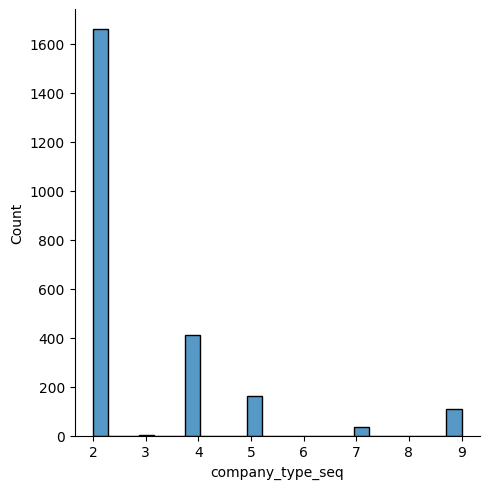

In [605]:
sns.displot(merged_recruitment, x = "company_type_seq")

In [606]:
merged_recruitment["company_type_seq"].value_counts()

2.0    1658
4.0     410
5.0     161
9.0     109
7.0      35
3.0       4
Name: company_type_seq, dtype: int64

In [607]:
# company_size 컬럼 생성
merged_recruitment['company_size'] = pd.cut(merged_recruitment['employee'],
    bins=[-1, 50, 300, 1000, float('inf')],
    labels=['소기업', '중소기업', '중견기업', '대기업'])

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 44204 (\N{HANGUL SYLLABLE GYEON}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44204 (\N{HANGUL SYLLABLE GYEON}) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  func(*a

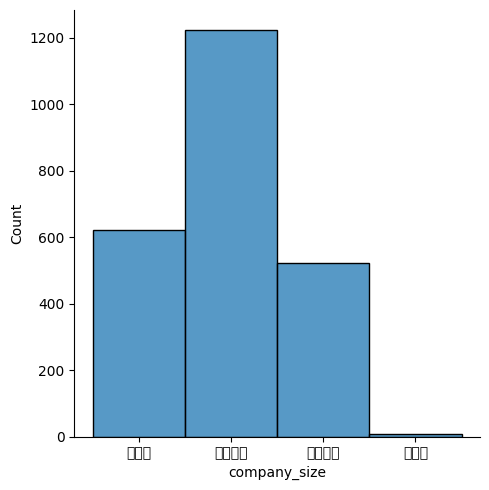

In [608]:
sns.displot(merged_recruitment, x="company_size")

In [609]:
merged_recruitment['company_size'].value_counts()

중소기업    1223
소기업      623
중견기업     523
대기업        8
Name: company_size, dtype: int64

In [610]:
merged_recruitment['company_size'] = merged_recruitment['company_size'].astype(str)

In [611]:
merged_recruitment['company_size'].fillna("미정기업", inplace = True)

In [612]:
merged_recruitment['company_type_seq'].value_counts()

2.0    1658
4.0     410
5.0     161
9.0     109
7.0      35
3.0       4
Name: company_type_seq, dtype: int64

In [613]:
merged_recruitment['company_type_seq'].fillna(0, inplace = True)

In [614]:
merged_recruitment['supply_kind'].value_counts()

402.0    1606
100.0     463
514.0     126
201.0     101
508.0      33
501.0      20
515.0       6
601.0       5
409.0       5
507.0       4
413.0       2
502.0       1
513.0       1
605.0       1
603.0       1
512.0       1
412.0       1
Name: supply_kind, dtype: int64

In [615]:
def supply_kind_range(type):
  if type == 402 :
    return 1
  elif type == 100 :
    return 2
  elif type == 514 :
    return 3
  elif type == 201 :
    return 4
  else:
    return 5

merged_recruitment['supply_kind'] = merged_recruitment['supply_kind'].apply(supply_kind_range)

In [616]:
def employee_cnt(cnt):
    if cnt >= 500:
        return 1
    elif cnt >= 100:
        return 2
    elif cnt >= 20:
        return 3
    elif cnt >= 1:
        return 4
    elif cnt == 0:
        return 5
    else:
        return 6
merged_recruitment['employee'] = merged_recruitment['employee'].apply(employee_cnt)

In [617]:
merged_recruitment['address_seq1'].fillna(3, inplace = True)

In [618]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   recruitment_seq      6695 non-null   object 
 1   address_seq1         6695 non-null   float64
 2   check_box_keyword    6695 non-null   object 
 3   education            6695 non-null   int64  
 4   major_task           6695 non-null   int64  
 5   qualifications       6695 non-null   int64  
 6   company_type_seq     6695 non-null   float64
 7   supply_kind          6695 non-null   int64  
 8   employee             6695 non-null   int64  
 9   main_code_26         6695 non-null   int64  
 10  main_code_29         6695 non-null   int64  
 11  main_code_23         6695 non-null   int64  
 12  main_code_21         6695 non-null   int64  
 13  main_code_28         6695 non-null   int64  
 14  main_code_31         6695 non-null   int64  
 15  main_code_22         6695 non-null   i

In [619]:
merged_recruitment['company_size'] = merged_recruitment['company_size'].astype(str)
merged_recruitment['company_size'].unique()

array(['중견기업', '중소기업', 'nan', '소기업', '대기업'], dtype=object)

In [620]:
merged_recruitment['company_size'].replace('nan',"미정기업", inplace = True)
merged_recruitment['company_size'].unique()

array(['중견기업', '중소기업', '미정기업', '소기업', '대기업'], dtype=object)

In [621]:
merged_recruitment['recruit_code'].unique()

array(['MD', '디자이너', '영업 및 관리', 'VMD', '기타'], dtype=object)

In [622]:
merged_recruitment['recruit_code'] = merged_recruitment['recruit_code'].astype("category")

In [623]:
merged_recruitment.drop(columns = 'check_box_keyword_1',inplace = True)
merged_recruitment.drop(columns = 'check_box_keyword', inplace= True)

In [624]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   float64 
 2   education         6695 non-null   int64   
 3   major_task        6695 non-null   int64   
 4   qualifications    6695 non-null   int64   
 5   company_type_seq  6695 non-null   float64 
 6   supply_kind       6695 non-null   int64   
 7   employee          6695 non-null   int64   
 8   main_code_26      6695 non-null   int64   
 9   main_code_29      6695 non-null   int64   
 10  main_code_23      6695 non-null   int64   
 11  main_code_21      6695 non-null   int64   
 12  main_code_28      6695 non-null   int64   
 13  main_code_31      6695 non-null   int64   
 14  main_code_22      6695 non-null   int64   
 15  main_code_25      6695 non-null   int64   
 16  main_code_27      6695 n

In [625]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
merged_recruitment['recruit_code'] = label_encoder.fit_transform(merged_recruitment['recruit_code'])
merged_recruitment['company_size'] = label_encoder.fit_transform(merged_recruitment['company_size'])

In [626]:
merged_recruitment.columns

Index(['recruitment_seq', 'address_seq1', 'education', 'major_task',
       'qualifications', 'company_type_seq', 'supply_kind', 'employee',
       'main_code_26', 'main_code_29', 'main_code_23', 'main_code_21',
       'main_code_28', 'main_code_31', 'main_code_22', 'main_code_25',
       'main_code_27', 'main_code_30', 'recruit_code', 'company_size'],
      dtype='object')

In [627]:
for col in ['address_seq1', 'education', 'major_task',
       'qualifications', 'company_type_seq', 'supply_kind', 'employee',
       'main_code_26', 'main_code_29', 'main_code_23', 'main_code_21',
       'main_code_28', 'main_code_31', 'main_code_22', 'main_code_25',
       'main_code_27', 'main_code_30', 'recruit_code', 'company_size']:
  merged_recruitment[col] = merged_recruitment[col].astype("category")

In [628]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   category
 2   education         6695 non-null   category
 3   major_task        6695 non-null   category
 4   qualifications    6695 non-null   category
 5   company_type_seq  6695 non-null   category
 6   supply_kind       6695 non-null   category
 7   employee          6695 non-null   category
 8   main_code_26      6695 non-null   category
 9   main_code_29      6695 non-null   category
 10  main_code_23      6695 non-null   category
 11  main_code_21      6695 non-null   category
 12  main_code_28      6695 non-null   category
 13  main_code_31      6695 non-null   category
 14  main_code_22      6695 non-null   category
 15  main_code_25      6695 non-null   category
 16  main_code_27      6695 n

In [629]:
merged_recruitment_tmp = merged_recruitment[['recruitment_seq']]

In [630]:
_train_encoded = pd.DataFrame()

for col in ['address_seq1', 'education', 'major_task',
       'qualifications', 'company_type_seq', 'supply_kind', 'employee',
       'main_code_26', 'main_code_29', 'main_code_23', 'main_code_21',
       'main_code_28', 'main_code_31', 'main_code_22', 'main_code_25',
       'main_code_27', 'main_code_30', 'recruit_code', 'company_size']: # 수정
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(merged_recruitment[col])
  _encoded = _encoder.transform(merged_recruitment[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

In [631]:
merged_recruitment_enc = pd.merge(merged_recruitment_tmp, _train_encoded, left_index=True, right_index=True, how='inner')

In [632]:
merged_recruitment_enc

,recruitment_seq,address_seq1_5.0,address_seq1_3.0,address_seq1_2.0,address_seq1_20.0,address_seq1_9.0,address_seq1_1.0,address_seq1_13.0,address_seq1_11.0,education_2.0,...,recruit_code_0.0,recruit_code_3.0,recruit_code_4.0,recruit_code_1.0,recruit_code_2.0,company_size_3.0,company_size_4.0,company_size_1.0,company_size_2.0,company_size_0.0
0,R00001,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
1,R00002,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2,R00003,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,R00004,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,R00005,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6691,R06692,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
6692,R06693,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
6693,R06694,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0


In [633]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   category
 2   education         6695 non-null   category
 3   major_task        6695 non-null   category
 4   qualifications    6695 non-null   category
 5   company_type_seq  6695 non-null   category
 6   supply_kind       6695 non-null   category
 7   employee          6695 non-null   category
 8   main_code_26      6695 non-null   category
 9   main_code_29      6695 non-null   category
 10  main_code_23      6695 non-null   category
 11  main_code_21      6695 non-null   category
 12  main_code_28      6695 non-null   category
 13  main_code_31      6695 non-null   category
 14  main_code_22      6695 non-null   category
 15  main_code_25      6695 non-null   category
 16  main_code_27      6695 n

In [634]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)
object_cols = list(merged_recruitment_object.columns)

for col in object_cols:
  merged_recruitment[col] = merged_recruitment[col].astype('category')

#형 변환 확인
merged_recruitment.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_recruitment_object = merged_recruitment.select_dtypes(exclude=np.number)\nobject_cols = list(merged_recruitment_object.columns)\n\nfor col in object_cols:\n  merged_recruitment[col] = merged_recruitment[col].astype('category')\n\n#형 변환 확인\nmerged_recruitment.info()\n"

### merged_resume 생성

In [567]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')

In [568]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()

In [569]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')

In [570]:
# resume_language 정렬 (resume_seq 기준)
resume_language = resume_language.sort_values(by='resume_seq')

- resume_language

In [571]:
def has_language(x, language):
    return int(language in x.values)

for language in resume_language['language'].unique():
    new_col_name = f'language_{language}'
    resume_language[new_col_name] = resume_language.groupby('resume_seq')['language'].transform(lambda x: has_language(x, language))

resume_language.drop_duplicates(subset='resume_seq', keep='first', inplace=True)
# resume_language.drop(['language', 'exam_name', 'score'], axis=1, inplace=True)
resume_language

KeyError: ignored

In [555]:
def convert_to_grade(row):
    lang = row['language']
    score = row['score']
    min_score, max_score = 0, 1000  # 범위를 직접 설정
    if lang in [2, 3, 4, 9]:
        if min_score <= score <= max_score:
            if 800 <= score <= 999:
                return 1
            elif 500 <= score < 700:
                return 2
            else:
                return 3
    else:                          # 8인 경우만 score 650
        return 2
resume_language['score'] = resume_language.apply(convert_to_grade, axis=1)
resume_language.drop(['language', 'exam_name', 'score'], axis=1, inplace=True)
resume_language.sort_values(by='resume_seq', inplace = True)
resume_language = resume_language.drop_duplicates(subset='resume_seq')

In [556]:
resume_language['lang_exist'] = resume_language['language_9'] + resume_language['language_2'] + resume_language['language_4'] + resume_language['language_3'] + resume_language['language_8']
resume_language = resume_language.drop_duplicates(subset='resume_seq')
resume_language['lang_exist']

45     1
701    1
205    1
645    1
769    1
      ..
424    1
728    1
278    1
212    1
707    1
Name: lang_exist, Length: 820, dtype: int64

In [557]:
resume_language.loc[resume_language['lang_exist'] != 0, "lang_exist"] = 1
resume_language

,resume_seq,language_2,language_4,language_3,language_9,language_8,lang_exist
45,U00004,1,0,0,0,0,1
701,U00005,1,0,0,0,0,1
205,U00039,1,0,0,0,0,1
645,U00054,1,0,0,0,0,1
769,U00067,1,0,0,0,0,1
...,...,...,...,...,...,...,...
424,U08443,0,1,0,0,0,1
728,U08461,1,0,0,0,0,1
278,U08465,1,0,0,0,0,1
212,U08472,1,0,0,0,0,1


- resume_education

In [558]:
def score_range(score):
  if score >= 5:
        if score >= 90:
            return 1
        elif score >= 80:
            return 2
        elif score >=70:
            return 3
        else:
            return 4
  else:
        if score >= 4.0:
            return 1
        elif score >= 3.5:
            return 2
        elif score >= 3.0:
            return 3
        else:
            return 4

resume_education['univ_score'] = resume_education['univ_score'].apply(score_range)

- resume_certificate

- 자격증 유무

In [560]:
resume_certificate

,resume_seq,certificate_contents
0,U00002,자동차 운전면허 (2종 보통)
1,U00003,운전면허2종보통;컬러리스트 기사;워드프로세서 1급
2,U00004,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT
3,U00006,운전면허 1종 보통;문서실무사1급;유통관리사 2급
4,U00007,샵마스터;자동차운전면허1종 보통;패턴 양장 기능사;MICROSOFT OFFICE E...
...,...,...
5971,U08476,운전면허2종보통
5972,U08479,컴퓨터그래픽스운용기능사
5973,U08480,2종 보통 운전면허증;컴퓨터그래픽스운용기능사;컬러리스트기사;컴퓨터패션디자인운용마스터
5974,U08481,컴퓨터활용능력 2급


In [561]:
resume_certificate["certificate_exist"] = 0
resume_certificate.loc[resume_certificate["certificate_contents"].notna(), "certificate_exist"] = 1
# resume_education["certificate_exist"] = resume_education["certificate_exist"].astype('category')

resume_certificate.head()

,resume_seq,certificate_contents,certificate_exist
0,U00002,자동차 운전면허 (2종 보통),1
1,U00003,운전면허2종보통;컬러리스트 기사;워드프로세서 1급,1
2,U00004,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT,1
3,U00006,운전면허 1종 보통;문서실무사1급;유통관리사 2급,1
4,U00007,샵마스터;자동차운전면허1종 보통;패턴 양장 기능사;MICROSOFT OFFICE E...,1


In [ ]:
resume_certificate = pd.DataFrame(resume_certificate, dtype=str)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(lambda x: ';'.join(x)).reset_index()
resume_certificate['certificate_cnt'] = resume_certificate['certificate_contents'].apply(lambda x: len(x.split(';')))
resume_certificate = resume_certificate.drop(columns = "certificate_contents", inplace = True)

- resume

In [562]:
resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
1690,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,NaN,0,NaN
3979,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,NaN,73,기타 공공;개인서비스
5648,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,NaN,113,섬유;봉제;가방;의류
1367,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,NaN,27,섬유;봉제;가방;의류
5242,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3811,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,NaN,60,섬유;봉제;가방;의류
2227,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,NaN,59,디자인;CAD;설계
2657,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,NaN,0,NaN
6619,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,NaN,8,섬유;봉제;가방;의류


In [563]:
mapping = {
    '재료·화학·섬유·의복': 1,
    '디자인': 2,
    '경영·기획·회계·사무': 3,
    '영업·판매·TM': 4,
    '건설·기계·전기·전자': 5,
    '전문·교육·자격':5,
    'IT·게임'            :6,
    '기타 직종'             :7,
    '문화·예술·신문·방송'       :8
}
resume['job_code_seq1'] = resume['job_code_seq1'].map(mapping)
resume.head()

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code
1690,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,1,NaN,NaN,0,NaN
3979,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,1,NaN,NaN,73,기타 공공;개인서비스
5648,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,1,NaN,NaN,113,섬유;봉제;가방;의류
1367,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,1,NaN,NaN,27,섬유;봉제;가방;의류
5242,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,1,NaN,NaN,0,NaN


In [564]:
resume['is_newbie'] = resume['career_month'].apply(lambda x: 0 if x < 12 else 1)
resume.head()

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,job_code_seq3,career_month,career_job_code,is_newbie
1690,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,1,NaN,NaN,0,NaN,0
3979,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,1,NaN,NaN,73,기타 공공;개인서비스,1
5648,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,1,NaN,NaN,113,섬유;봉제;가방;의류,1
1367,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,1,NaN,NaN,27,섬유;봉제;가방;의류,1
5242,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,1,NaN,NaN,0,NaN,0


In [565]:
careeer_job_code_mapping = {
    '섬유;봉제;가방;의류' : 1,
    '도소매;유통;무역'    : 2,
    '디자인;CAD;설계'     : 3,
}

resume['career_job_code'] = resume['career_job_code'].map(careeer_job_code_mapping)

def else_career(career_code):
  if career_code != 1 or career_code != 2 or career_code != 3:
    return 4

resume['career_job_code'] = resume['career_job_code'].apply(else_career)

In [566]:
def career_range(career):
  if career >= 60: # 5년이상 1
    return 1
  elif career >= 12: # 1년이상 2
    return 2
  elif career >= 1: # 경력 1개월 이상 3
    return 3
  else :
    return 4

resume['career_month'] = resume['career_month'].apply(career_range)

In [474]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

TypeError: ignored

In [393]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             8482 non-null   object 
 1   reg_date               8482 non-null   object 
 2   updated_date           8482 non-null   object 
 3   degree                 8482 non-null   int64  
 4   graduate_date          8482 non-null   int64  
 5   hope_salary            8482 non-null   float64
 6   last_salary            8482 non-null   float64
 7   text_keyword           8287 non-null   object 
 8   job_code_seq1          8482 non-null   int64  
 9   job_code_seq2          500 non-null    object 
 10  job_code_seq3          187 non-null    object 
 11  career_month           8482 non-null   int64  
 12  career_job_code        8482 non-null   int64  
 13  is_newbie              8482 non-null   int64  
 14  certificate_contents   5976 non-null   object 
 15  cert

In [394]:
merged_resume.describe()

,degree,graduate_date,hope_salary,last_salary,job_code_seq1,career_month,career_job_code,is_newbie,certificate_cnt,hischool_type_seq,...,univ_type_seq2,univ_transfer,univ_location,univ_major_type,univ_score,language_2,language_4,language_3,language_9,language_8
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.0,8482.000000,5976.000000,8482.000000,...,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,3.938222,1819.586065,1395.095496,2505.706201,1.240274,1.843669,4.0,0.815256,2.170515,16.402499,...,4.684626,0.004480,6.651733,8.095143,2.429498,0.843902,0.085366,0.070732,0.010976,0.001220
std,0.440764,584.009224,1865.951253,2010.082733,0.657135,1.008904,0.0,0.388113,1.424075,8.485975,...,1.892880,0.066787,5.272027,5.152574,0.888975,0.363169,0.279596,0.256533,0.104252,0.034922
min,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.0,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2001.000000,0.000000,0.000000,1.000000,1.000000,4.0,1.000000,1.000000,20.000000,...,5.000000,0.000000,3.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2007.000000,0.000000,2700.000000,1.000000,2.000000,4.0,1.000000,2.000000,21.000000,...,5.000000,0.000000,5.000000,9.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2011.000000,2700.000000,3700.000000,1.000000,2.000000,4.0,1.000000,3.000000,21.000000,...,5.000000,0.000000,10.000000,9.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,2022.000000,10000.000000,10000.000000,8.000000,4.000000,4.0,1.000000,10.000000,23.000000,...,12.000000,1.000000,19.000000,23.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- merged_resume 상관관계

<ipython-input-239-46499a0805dc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_resume.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')


<Axes: >

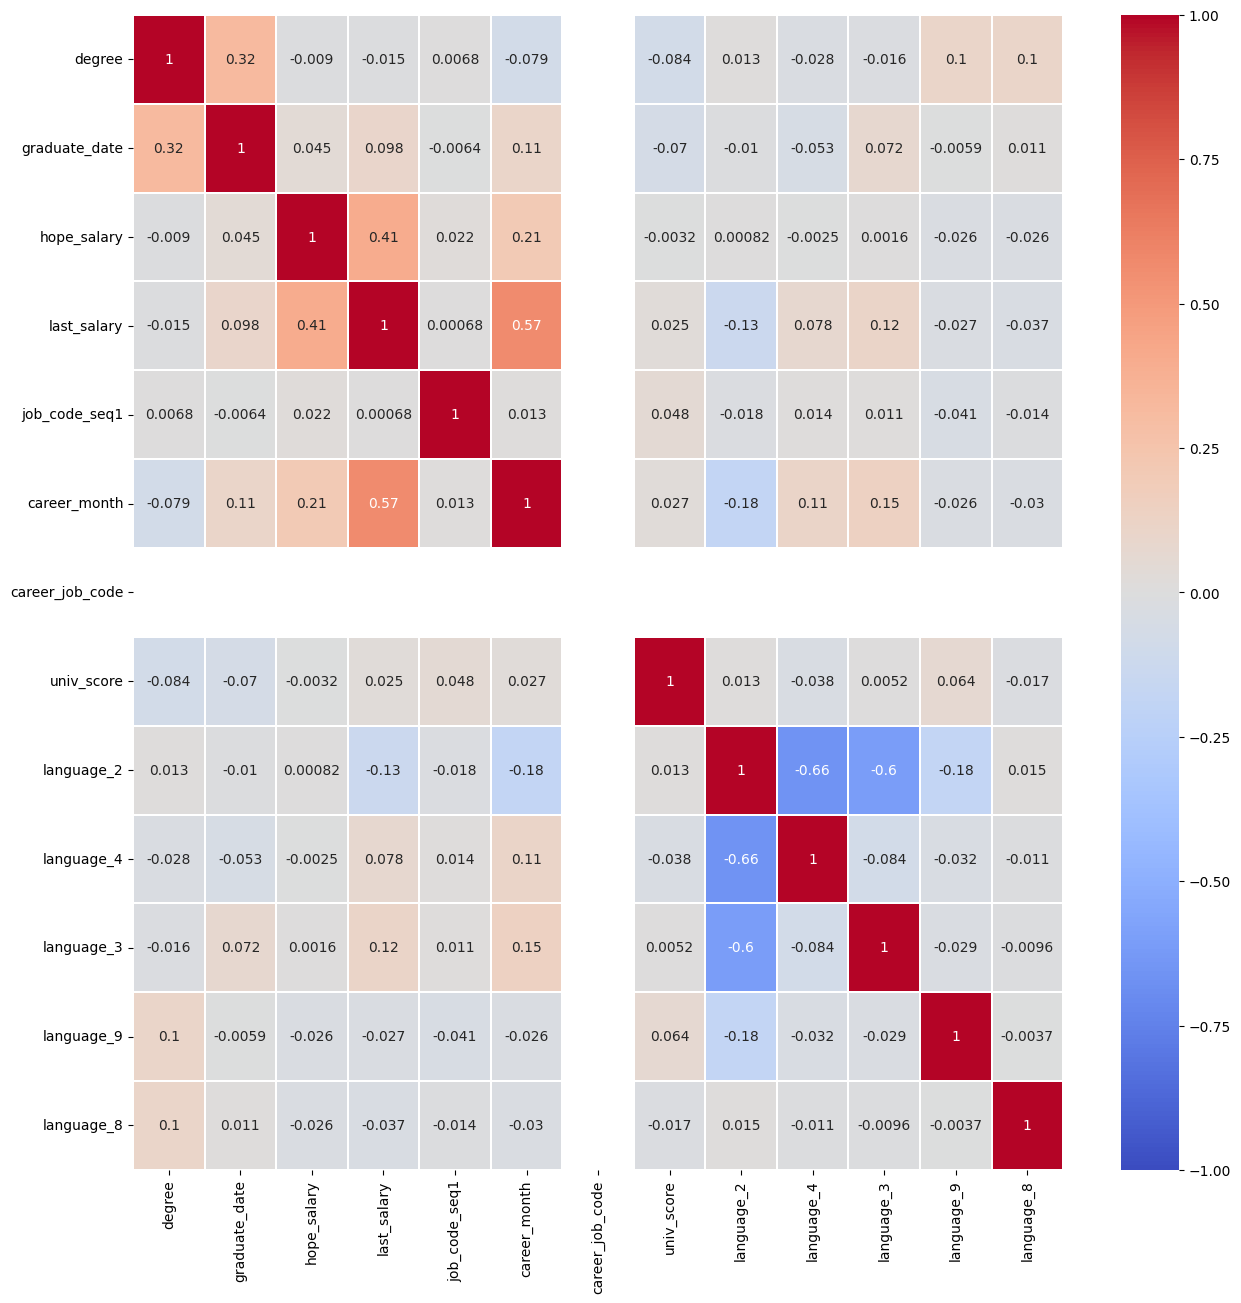

In [239]:
plt.figure(figsize=(15, 15))
sns.heatmap(merged_resume.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

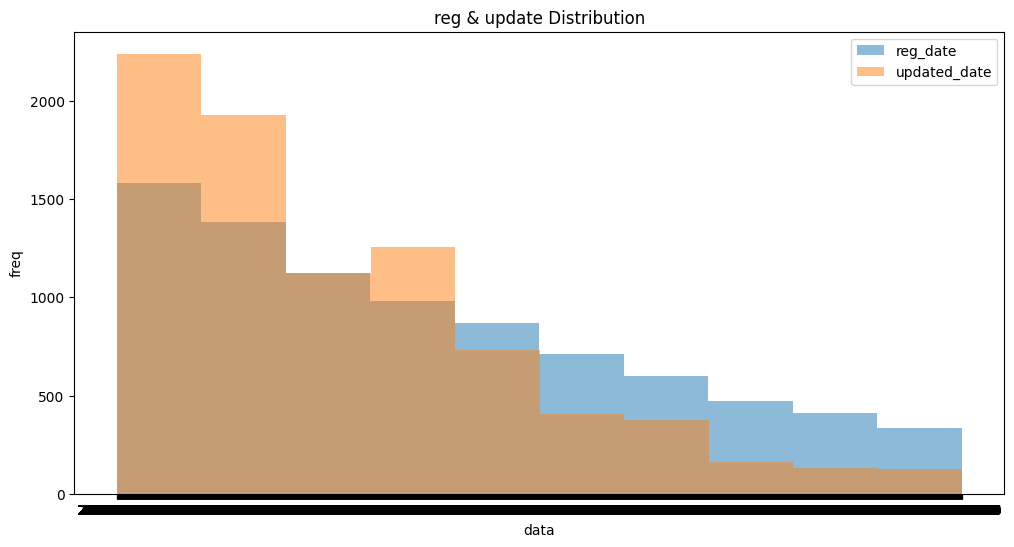

In [240]:
plt.figure(figsize=(12, 6))
plt.hist(merged_resume['reg_date'], alpha=0.5, label='reg_date', bins=10)
plt.hist(merged_resume['updated_date'], alpha=0.5, label='updated_date', bins=10)
plt.xlabel('data')
plt.ylabel('freq')
plt.legend(loc='upper right')
plt.title('reg & update Distribution')
plt.show()

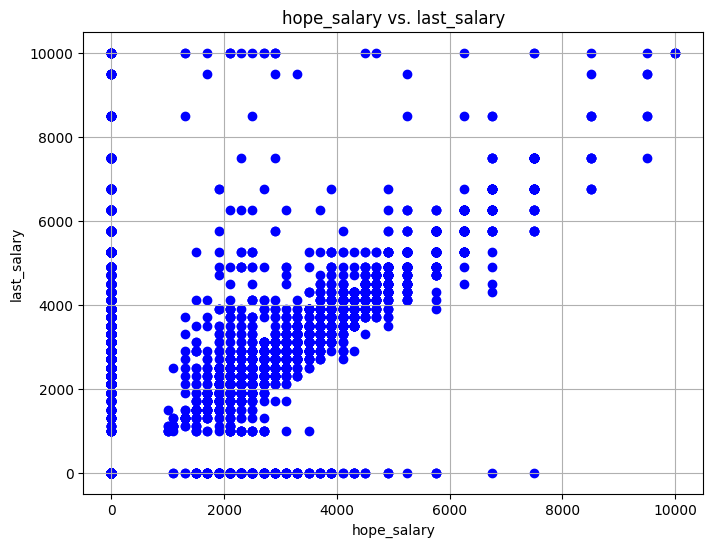

In [241]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_resume['hope_salary'], merged_resume['last_salary'], marker='o', color='b')
plt.xlabel('hope_salary')
plt.ylabel('last_salary')
plt.title('hope_salary vs. last_salary')
plt.grid(True)

### merged_resume 탐색 & drop

In [395]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             8482 non-null   object 
 1   reg_date               8482 non-null   object 
 2   updated_date           8482 non-null   object 
 3   degree                 8482 non-null   int64  
 4   graduate_date          8482 non-null   int64  
 5   hope_salary            8482 non-null   float64
 6   last_salary            8482 non-null   float64
 7   text_keyword           8287 non-null   object 
 8   job_code_seq1          8482 non-null   int64  
 9   job_code_seq2          500 non-null    object 
 10  job_code_seq3          187 non-null    object 
 11  career_month           8482 non-null   int64  
 12  career_job_code        8482 non-null   int64  
 13  is_newbie              8482 non-null   int64  
 14  certificate_contents   5976 non-null   object 
 15  cert

In [396]:
merged_resume.describe()

,degree,graduate_date,hope_salary,last_salary,job_code_seq1,career_month,career_job_code,is_newbie,certificate_cnt,hischool_type_seq,...,univ_type_seq2,univ_transfer,univ_location,univ_major_type,univ_score,language_2,language_4,language_3,language_9,language_8
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.0,8482.000000,5976.000000,8482.000000,...,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,820.000000,820.000000,820.000000,820.000000,820.000000
mean,3.938222,1819.586065,1395.095496,2505.706201,1.240274,1.843669,4.0,0.815256,2.170515,16.402499,...,4.684626,0.004480,6.651733,8.095143,2.429498,0.843902,0.085366,0.070732,0.010976,0.001220
std,0.440764,584.009224,1865.951253,2010.082733,0.657135,1.008904,0.0,0.388113,1.424075,8.485975,...,1.892880,0.066787,5.272027,5.152574,0.888975,0.363169,0.279596,0.256533,0.104252,0.034922
min,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.0,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2001.000000,0.000000,0.000000,1.000000,1.000000,4.0,1.000000,1.000000,20.000000,...,5.000000,0.000000,3.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2007.000000,0.000000,2700.000000,1.000000,2.000000,4.0,1.000000,2.000000,21.000000,...,5.000000,0.000000,5.000000,9.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2011.000000,2700.000000,3700.000000,1.000000,2.000000,4.0,1.000000,3.000000,21.000000,...,5.000000,0.000000,10.000000,9.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,2022.000000,10000.000000,10000.000000,8.000000,4.000000,4.0,1.000000,10.000000,23.000000,...,12.000000,1.000000,19.000000,23.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [397]:
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_score               0.000000
univ_major_type          0.000000
univ_location            0.000000
univ_transfer            0.000000
univ_type_seq2           0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
is_newbie                0.000000
hischool_type_seq        0.000000
career_month             0.000000
reg_date                 0.000000
updated_date             0.000000
degree                   0.000000
career_job_code          0.000000
hope_salary              0.000000
last_salary              0.000000
graduate_date            0.000000
job_code_seq1            0.000000
text_keyword             0.022990
certificate_cnt          0.295449
certificate_contents     0.295449
univ_major               0.788375
language_9               0.903325
language_2               0.903325
language_4               0.903325
language_3    

<Axes: >

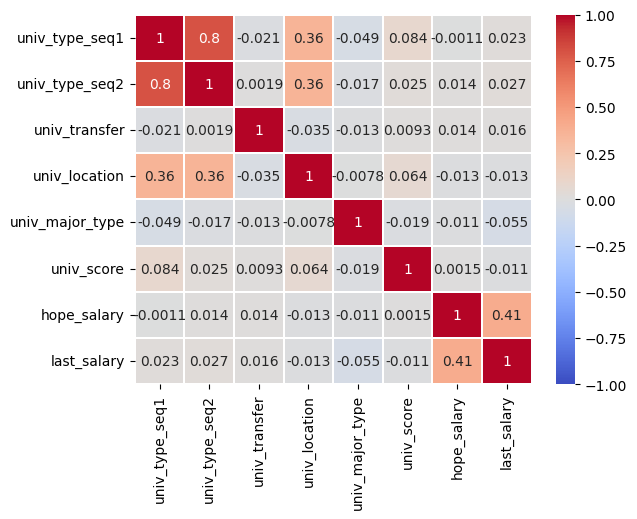

In [ ]:
col = merged_resume[['univ_type_seq1', 'univ_type_seq2',
                        'univ_transfer', 'univ_location',
                        'univ_major_type', 'univ_score',
                        'hope_salary', 'last_salary']]

sns.heatmap(col.corr(),vmin=-1,vmax=1,annot=True,linewidths=0.2,cmap='coolwarm')

In [ ]:
merged_resume_drop_col = ['job_code_seq2', 'job_code_seq3', 'univ_sub_major', 'univ_major', 'reg_date', 'updated_date']
merged_resume = merged_resume.drop(merged_resume_drop_col, axis=1)
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
univ_score               0.000000
univ_major_type          0.000000
univ_location            0.000000
univ_transfer            0.000000
univ_type_seq2           0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_special_type    0.000000
hischool_nation          0.000000
career_month             0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
hischool_type_seq        0.000000
text_keyword             0.022990
career_job_code          0.089366
certificate_contents     0.295449
language_9               0.903325
language_2               0.903325
language_4               0.903325
language_3               0.903325
language_8               0.903325
dtype: float64

In [ ]:
# fillna_col = ['career_job_code']

# for col in fillna_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
#   col_mode = merged_resume[col].mode().values[0]
#   merged_resume[col].fillna(col_mode, inplace=True)

fillna_0_col = ['language_9', 'language_2', 'language_4', 'language_3', 'language_8']

for col in fillna_0_col: #for문을 돌면서 각 컬럼에 대한 최빈값으로 채움
  merged_resume[col].fillna(0, inplace=True)

(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq               0.000000
language_3               0.000000
language_4               0.000000
language_2               0.000000
univ_score               0.000000
univ_major_type          0.000000
univ_location            0.000000
univ_transfer            0.000000
univ_type_seq2           0.000000
univ_type_seq1           0.000000
hischool_location_seq    0.000000
hischool_gender          0.000000
hischool_nation          0.000000
hischool_special_type    0.000000
hischool_type_seq        0.000000
career_job_code          0.000000
career_month             0.000000
job_code_seq1            0.000000
last_salary              0.000000
hope_salary              0.000000
graduate_date            0.000000
degree                   0.000000
language_9               0.000000
language_8               0.000000
text_keyword             0.022990
certificate_contents     0.295449
dtype: float64

In [ ]:
# merged_resume['job_code_seq1'].unique()

array(['재료·화학·섬유·의복', '디자인', '경영·기획·회계·사무', '영업·판매·TM', '건설·기계·전기·전자',
       'IT·게임', '전문·교육·자격', '기타 직종', '문화·예술·신문·방송'], dtype=object)

In [ ]:
# merged_resume['career_job_code'].unique()

array(['섬유;봉제;가방;의류', '기타 공공;개인서비스', '광고;홍보', '도소매;유통;무역',
       '영화;방송;공연;문화;스포츠', '기타 서비스', '디자인;CAD;설계', '호텔;숙박;관광;여행;외식',
       '쇼핑몰;전자상거래;경매', '생활용품;화장품;완구', '운송;운수;통신', '반도체;LCD;광학;정밀',
       '금융;보험;증권', '게임;캐릭터;애니메이션', '공공행정;경찰;기관;협회', '기계;각종 장비',
       '컴퓨터;사무기기;소비재', '식음료;식품가공', '의료;제약;건강', '기타 제조', '솔루션/ASP',
       '모바일;유무선', '건설;토목;건축', '출판;인쇄;편집;영상', '학교;학원;직원훈련(교육서비스)',
       '철강;금속;비금속;재료', '전기;전자;통신장비', '화학;고무;플라스틱', '인력공급;시설유지;TM(용역;도급)',
       'IT 컨설팅;조사분석;통계', '네트워크;통신;텔레콤', '법률;회계;세무;특허', '신문;서적;출판;인쇄',
       '자동차;운송장비;조선;항공', '전기;가스;수도;에너지', '병원;제약;사회복지', '목재;나무;종이;가구',
       '웹에이전시', '인터넷서비스;포털;컨텐츠', '부동산;임대업', 'SI/ERP/CRM'], dtype=object)

In [ ]:
target_columns = ['job_code_seq1', 'career_job_code', 'hischool_special_type', 'hischool_nation', 'hischool_gender']

# 각 컬럼에 대해 매핑 수행
# 각 unique()의 index + 1의 값으로 대입
for column in target_columns:
    unique_values = merged_resume[column].unique()
    mapping = {value: index + 1 for index, value in enumerate(unique_values)}
    merged_resume[column] = merged_resume[column].map(mapping)

merged_resume

,resume_seq,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,career_month,career_job_code,certificate_contents,...,univ_type_seq2,univ_transfer,univ_location,univ_major_type,univ_score,language_2,language_4,language_3,language_9,language_8
0,U00001,4,2009,1500.0,1500.0,디자이너,1,0,1,NaN,...,5,0,17,9,20.0,0.0,0.0,0.0,0.0,0.0
1,U00002,4,2005,0.0,0.0,디자이너,1,73,2,자동차 운전면허 (2종 보통),...,5,0,3,8,90.0,0.0,0.0,0.0,0.0,0.0
2,U00003,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,1,113,1,운전면허2종보통;컬러리스트 기사;워드프로세서 1급,...,5,0,17,4,90.0,0.0,0.0,0.0,0.0,0.0
3,U00004,4,2011,0.0,0.0,상품기획;영업기획,1,27,1,정보처리기능사;유통관리사 2급;MOS EXCEL 2003 EXPERT,...,5,0,5,3,70.0,1.0,0.0,0.0,0.0,0.0
4,U00005,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,1,0,1,NaN,...,0,0,0,10,50.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,4,2003,0.0,2700.0,상품기획,1,60,1,NaN,...,5,0,5,19,0.0,0.0,0.0,0.0,0.0,0.0
8478,U08479,3,0,2500.0,2300.0,디자이너,1,59,7,컴퓨터그래픽스운용기능사,...,6,0,3,9,0.0,0.0,0.0,0.0,0.0,0.0
8479,U08480,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,2,0,1,2종 보통 운전면허증;컴퓨터그래픽스운용기능사;컬러리스트기사;컴퓨터패션디자인운용마스터,...,5,0,10,9,80.0,0.0,0.0,0.0,0.0,0.0
8480,U08481,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,1,8,1,컴퓨터활용능력 2급,...,5,0,5,9,60.0,0.0,0.0,0.0,0.0,0.0


- language : 언어 자격증을 가지고 있는지 유무로 나누자
  - 언어 자격증 소유 : 1 / 미소유 : 0
- certificate_contents : 자격증을 가지고 있는지 유무로 나누자
  - 자격증 소유 : 1 / 미소유 : 0
- certificate_contents의 갯수가 중요할까?

In [ ]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   resume_seq             8482 non-null   object  
 1   degree                 8482 non-null   int64   
 2   graduate_date          8482 non-null   int64   
 3   hope_salary            8482 non-null   float64 
 4   last_salary            8482 non-null   float64 
 5   text_keyword           8287 non-null   object  
 6   job_code_seq1          8482 non-null   int64   
 7   career_month           8482 non-null   int64   
 8   career_job_code        8482 non-null   int64   
 9   hischool_type_seq      8482 non-null   int64   
 10  hischool_special_type  8482 non-null   int64   
 11  hischool_nation        8482 non-null   int64   
 12  hischool_gender        8482 non-null   int64   
 13  hischool_location_seq  8482 non-null   int64   
 14  univ_type_seq1         8482 non-null   i

- 직무키워드(text_keyword)


In [ ]:
merged_resume["text_keyword"]

0                                 디자이너
1                                 디자이너
2                        남성복디자이너;TD캐주얼
3                            상품기획;영업기획
4                     인사;총무;경영;MD;상품기획
                     ...              
8477                              상품기획
8478                              디자이너
8479    VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인
8480                   상품기획;머천다이저;기획MD
8481       상품기획;영업MD;머천다이저;기획MD;마케팅;PR
Name: text_keyword, Length: 8482, dtype: object

In [ ]:
type(merged_resume["text_keyword"])

pandas.core.series.Series

In [ ]:
# from math import log

In [ ]:
vocab = list(set(w for doc in merged_resume["text_keyword"].astype(str) for w in doc.split(";")))
vocab.sort()
vocab

['10년차',
 '20대',
 '2등골프웨어영업대리점',
 '3DMAX',
 '3년차',
 '4대보험',
 '5년차디자이너',
 '6시그마',
 'ACC',
 'ACCESSORY',
 'ACCMD',
 'ACC디자이너',
 'ACC디자인',
 'AD',
 'AE',
 'AGENCY',
 'AI',
 'AMD',
 'ARTWORK디자인',
 'ATL',
 'BI',
 'BI관리',
 'BM',
 'BTL',
 'BUYER',
 'BUYING',
 'BUYINGMD',
 'CAD',
 'CADTEXPRO',
 'CD',
 'CEO',
 'CFO',
 'CG',
 'CI',
 'CMO',
 'COLORIST',
 'CORELDRAW',
 'CRM',
 'CRMMD',
 'CRM관리',
 'CS',
 'CS고객상담',
 'CTO',
 'DEMANDPLANNING',
 'DEMIN',
 'DESIGNRD',
 'DISPLAY',
 'DP',
 'DTP',
 'ENGLISH',
 'ERP사용',
 'EXCEL',
 'FABRIC',
 'FABRICRD',
 'FABRICSOURCING',
 'FASHION',
 'FASHIONMD',
 'FG',
 'FG디자이너',
 'FIT',
 'FITTECHNICIAN',
 'FORECASTING',
 'GLOBALBUSINESS',
 'GRAPHIC',
 'HR',
 'HRD',
 'HRM',
 'IBM',
 'IMC',
 'IR',
 'ISO',
 'JERSEY',
 'K2',
 'KNIT',
 'KNIT해외영업',
 'KYJ회계',
 'LC',
 'LCD',
 'LCD영업',
 'LC관련수출입업무',
 'LED',
 'MARKETING',
 'MAX',
 'MBA',
 'MD',
 'MDMR',
 'MDPLANNING',
 'MDVMD',
 'MDVMDBUYER',
 'MDVMD스타일리스트',
 'MD기획',
 'MD기획MD',
 'MD디자이너생산영업',
 'MD마케팅',
 'MD마케팅머천다이저상품기획',
 'MD머천다이저'

In [ ]:
type(vocab)

list

In [ ]:
merged_resume["text_keyword"].fillna("0", inplace = True)

In [ ]:
for vo in vocab:
  merged_resume[f'text_{vo}'] = merged_resume['text_keyword'].apply(lambda x: 1 if pd.notna(x) and vo in x else 0)
  merged_resume[f'text_{vo}'].astype(int)
  merged_resume[f'text_{vo}'].astype("category")
merged_resume

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
<ipython-input-76-8540b072e401>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_resume[f'text_{vo}'] = merged_resume['text_keyword'].apply(lambda x: 1 if pd.notna(x) and vo in x else 0)
<ipython-input-76-8540b072e401>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_resume[f'text_{vo}'] = merged_resume['text_keyword'].apply(lambda x: 1 if pd.notna(x) and vo in x else 0)
<ipython-input-76-8540b072e401>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the re

,resume_seq,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,career_job_code,hischool_type_seq,hischool_special_type,...,text_활발,text_회계,text_회계사,text_회계사무,text_회계업무,text_회계재무자금,text_회로설계,text_회원관리,text_회화,text_휘트니스웨어
0,U00001,4,2009,1500.0,1500.0,디자이너,1,1,21,1,...,0,0,0,0,0,0,0,0,0,0
1,U00002,4,2005,0.0,0.0,디자이너,1,2,0,2,...,0,0,0,0,0,0,0,0,0,0
2,U00003,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,1,1,21,1,...,0,0,0,0,0,0,0,0,0,0
3,U00004,4,2011,0.0,0.0,상품기획;영업기획,1,1,21,1,...,0,0,0,0,0,0,0,0,0,0
4,U00005,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,1,1,21,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,U08478,4,2003,0.0,2700.0,상품기획,1,1,21,1,...,0,0,0,0,0,0,0,0,0,0
8478,U08479,3,0,2500.0,2300.0,디자이너,1,7,21,3,...,0,0,0,0,0,0,0,0,0,0
8479,U08480,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,2,1,0,2,...,0,0,0,0,0,0,0,0,0,0
8480,U08481,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,1,1,21,3,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
(merged_resume.isnull().sum() / len(merged_resume)).sort_values()

resume_seq       0.0
text_우븐가능        0.0
text_우븐경력디자이너    0.0
text_우븐구매        0.0
text_우븐니트디자인     0.0
                ... 
text_반도체장비       0.0
text_발광다이오드      0.0
text_발주          0.0
text_방송기획        0.0
text_휘트니스웨어      0.0
Length: 2912, dtype: float64

In [ ]:
merged_resume.isnull().sum().sum()

0

- 이력서 등록일(reg_date)
  - 분기별로 나누자?

In [ ]:
# plt.figure(figsize=(12, 6))
# merged_resume['reg_date'].value_counts().sort_index().plot()
# plt.title('Distribution of "reg_date"')
# plt.xlabel('Date')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # 2019년 부터 2020년 사이에 이력서 등록량 증가

- 연봉확인

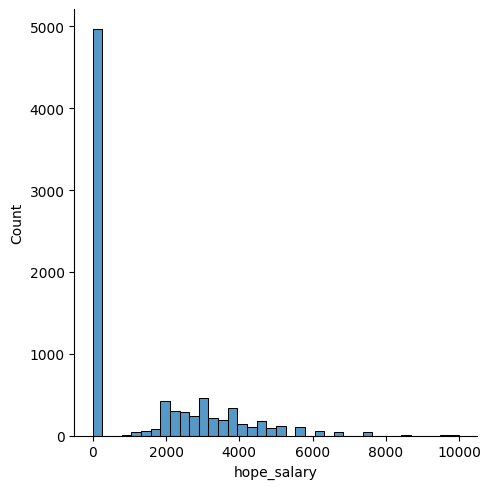

In [ ]:
sns.displot(merged_resume, x = "hope_salary")

In [ ]:
'''
#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환
merged_resume_object = merged_resume.select_dtypes(exclude=np.number)
object_cols = list(merged_resume_object.columns)

for col in object_cols:
  merged_resume[col] = merged_resume[col].astype('category')

#형 변환 확인
merged_resume.info()
'''

"\n#문자형(object type)을 LightGBM에 사용할 수 있도록 Category 형태로 형 변환\nmerged_resume_object = merged_resume.select_dtypes(exclude=np.number)\nobject_cols = list(merged_resume_object.columns)\n\nfor col in object_cols:\n  merged_resume[col] = merged_resume[col].astype('category')\n\n#형 변환 확인\nmerged_resume.info()\n"

## merged_total EDA

### merged_total 생성

In [ ]:
_merged_total = pd.merge(apply_train, merged_recruitment, left_on='recruitment_seq', right_on='recruitment_seq', how='left')
_merged_total = pd.merge(_merged_total, merged_resume, left_on='resume_seq', right_on='resume_seq', how='left')
merged_total = _merged_total
merged_total.head()

,resume_seq,recruitment_seq,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_23,main_code_27,...,text_활발,text_회계,text_회계사,text_회계사무,text_회계업무,text_회계재무자금,text_회로설계,text_회원관리,text_회화,text_휘트니스웨어
0,U05833,R03838,3.0,3,2,1,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,U06456,R02144,3.0,3,2,1,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,U07807,R01877,3.0,3,2,1,4.0,402.0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,U04842,R02463,3.0,4,2,1,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,U08336,R00112,3.0,3,8,1,0.0,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57946 entries, 0 to 57945
Columns: 2932 entries, resume_seq to text_휘트니스웨어
dtypes: category(5), float64(11), int64(2911), object(5)
memory usage: 1.3+ GB


- 자격증일정갯수 소지하면 요건난이도(qualifications) 확인

In [ ]:
merged_total.head()

,resume_seq,recruitment_seq,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_30,main_code_26,...,text_활발,text_회계,text_회계사,text_회계사무,text_회계업무,text_회계재무자금,text_회로설계,text_회원관리,text_회화,text_휘트니스웨어
0,U05833,R03838,3.0,3,2,1,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,U06456,R02144,3.0,3,2,1,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,U07807,R01877,3.0,3,2,1,4.0,402.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,U04842,R02463,3.0,4,2,1,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,U08336,R00112,3.0,3,8,1,0.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_total["qualifications"].unique()

array([1, 2, 0])

In [ ]:
merged_total["certificate_cnt"].unique()

[2, 1, 0, 8, 5, ..., 3, 6, 7, 10, 9]
Length: 11
Categories (11, int64): [0, 1, 2, 3, ..., 7, 8, 9, 10]

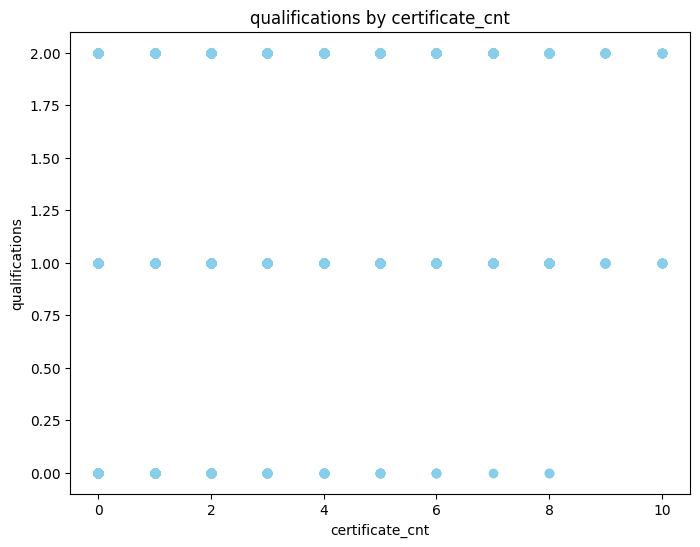

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(merged_total['certificate_cnt'], merged_total['qualifications'], color='skyblue')
plt.xlabel('certificate_cnt')
plt.ylabel('qualifications')
plt.title('qualifications by certificate_cnt')
plt.show()

자격증일정갯수 소지하면 요건난이도(qualifications)는 의미가 없는 것 같다

- 최종학력(degree) + 요구학위(education)
  - 최종학력이 요구학위 이상이면 1 아니면 0

In [ ]:
# merged_total["degree"].unique()

In [ ]:
# merged_total["education"].unique()

In [ ]:
# degree_education = merged_total[['recruitment_seq']].copy()

In [ ]:
# degree_education['degree_education'] = (merged_total['degree'] >= merged_total['education']).astype(int)

# degree_education

In [ ]:
# merged_recruitment["degree_education"] = pd.merge(merged_recruitment, degree_education, on='recruitment_seq', how='left')

## category 형 변환 & Scaling

In [ ]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   float64 
 2   education         6695 non-null   int64   
 3   major_task        6695 non-null   int64   
 4   qualifications    6695 non-null   int64   
 5   company_type_seq  6695 non-null   float64 
 6   supply_kind       6695 non-null   float64 
 7   main_code_26      6695 non-null   int64   
 8   main_code_31      6695 non-null   int64   
 9   main_code_22      6695 non-null   int64   
 10  main_code_29      6695 non-null   int64   
 11  main_code_21      6695 non-null   int64   
 12  main_code_28      6695 non-null   int64   
 13  main_code_25      6695 non-null   int64   
 14  main_code_27      6695 non-null   int64   
 15  main_code_23      6695 non-null   int64   
 16  main_code_30      6695 n

In [ ]:
merged_recruitment.describe()

,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_26,main_code_31,main_code_22,main_code_29,main_code_21,main_code_28,main_code_25,main_code_27,main_code_23,main_code_30
count,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000,6695.000000
mean,3.103659,3.081703,2.277521,1.317401,1.045407,122.166094,0.000448,0.004780,0.601942,0.000747,0.485138,0.110381,0.438387,0.927558,0.020015,0.024496
std,0.955388,0.753074,1.242267,0.477852,1.749139,182.286727,0.021165,0.068975,0.489534,0.027320,0.499816,0.313387,0.496226,0.259238,0.140062,0.154594
min,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,3.000000,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,3.000000,4.000000,2.000000,2.000000,2.000000,402.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,20.000000,6.000000,10.000000,2.000000,9.000000,605.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
rc_scaling_col = []
rc_category_col = list(set(merged_recruitment.columns) - set(rc_scaling_col) - set(['recruitment_seq']) )

In [ ]:
for col in rc_scaling_col:
  merged_recruitment[col] = merged_recruitment[col].map(lambda i: np.log(i) if i > 0 else 0)

In [ ]:
merged_recruitment[rc_category_col] = merged_recruitment[rc_category_col].astype('category')

In [ ]:
merged_recruitment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6695 entries, 0 to 6694
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   recruitment_seq   6695 non-null   object  
 1   address_seq1      6695 non-null   category
 2   education         6695 non-null   category
 3   major_task        6695 non-null   category
 4   qualifications    6695 non-null   category
 5   company_type_seq  6695 non-null   category
 6   supply_kind       6695 non-null   category
 7   main_code_23      6695 non-null   category
 8   main_code_27      6695 non-null   category
 9   main_code_31      6695 non-null   category
 10  main_code_25      6695 non-null   category
 11  main_code_29      6695 non-null   category
 12  main_code_21      6695 non-null   category
 13  main_code_28      6695 non-null   category
 14  main_code_26      6695 non-null   category
 15  main_code_22      6695 non-null   category
 16  main_code_30      6695 n

In [ ]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8482 entries, 0 to 8481
Columns: 2912 entries, resume_seq to text_휘트니스웨어
dtypes: category(4), float64(8), int64(2898), object(2)
memory usage: 188.5+ MB


In [ ]:
merged_resume.describe()

,degree,graduate_date,hope_salary,last_salary,job_code_seq1,career_job_code,hischool_type_seq,hischool_special_type,hischool_nation,hischool_gender,...,text_활발,text_회계,text_회계사,text_회계사무,text_회계업무,text_회계재무자금,text_회로설계,text_회원관리,text_회화,text_휘트니스웨어
count,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,...,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000,8482.000000
mean,3.938222,1819.586065,1395.095496,2505.706201,1.241217,3.898373,16.402499,1.494341,2.092077,2.429144,...,0.000118,0.004244,0.000236,0.000118,0.000118,0.000118,0.000118,0.000118,0.000472,0.000118
std,0.440764,584.009224,1865.951253,2010.082733,0.664642,6.511456,8.485975,0.887508,0.887299,1.106301,...,0.010858,0.065014,0.015355,0.010858,0.010858,0.010858,0.010858,0.010858,0.021712,0.010858
min,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,2001.000000,0.000000,0.000000,1.000000,1.000000,20.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2007.000000,0.000000,2700.000000,1.000000,1.000000,21.000000,1.000000,2.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2011.000000,2700.000000,3700.000000,1.000000,4.000000,21.000000,2.000000,3.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6.000000,2022.000000,10000.000000,10000.000000,9.000000,41.000000,23.000000,5.000000,3.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
rs_scaling_col = ['hope_salary', 'last_salary', 'graduate_date']
rs_category_col = list(set(merged_resume.columns) - set(rs_scaling_col) - set(['resume_seq']) )

In [ ]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
_scaled_rs = std.fit_transform(merged_resume[rs_scaling_col])

In [ ]:
tmp = pd.DataFrame(
    _scaled_rs,
    columns = rs_scaling_col
)
_merged_resume = pd.concat(
    [merged_resume[rs_category_col].reset_index(drop=True), tmp.reset_index(drop=True)]
    , axis=1
).reset_index(drop=True)

_merged_resume['resume_seq'] = merged_resume['resume_seq']

merged_resume = _merged_resume

In [ ]:
merged_resume[rs_category_col]

,text_PSD,text_상품운영,text_영업MD의전반적인업무,text_디자인실총괄디자이너,text_KNIT해외영업,text_악세서리,text_패턴기획,text_CD,text_패션머천다이져,text_패션정보컬설팅트랜드분석등등,...,text_브랜드PR,text_매장개설및영업관리,text_운송,text_사무자동화산업기사,text_패션디자이너오미화,text_영업기획MD컬러리스트,text_프로모션기획,text_캐주얼웨어디자이너,text_유통바이어,text_임금관리
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8477,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
merged_resume[rs_category_col] = merged_resume[rs_category_col].astype('category')

In [ ]:
merged_resume.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Columns: 2912 entries, text_PSD to resume_seq
dtypes: category(2908), float64(3), object(1)
memory usage: 24.3+ MB


# Negative Sampling

In [ ]:
#학습, 검증 분리
apply_train_list_tr, apply_train_list_te = [], []
apply_train_groupby = apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(apply_train_groupby.index.tolist(), apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        apply_train_list_tr.append([uid,iid])
    apply_train_list_te.append([uid, iids[-1]])

In [ ]:
apply_train_tr = pd.DataFrame(apply_train_list_tr, columns=['resume_seq', 'recruitment_seq'])
apply_train_te = pd.DataFrame(apply_train_list_te, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
#학습, 검증 모두 결과값은 같음
resume_pool = set(apply_train["resume_seq"].unique())
recruitment_pool = set(apply_train['recruitment_seq'].unique())

len(resume_pool), len(recruitment_pool)

(8482, 6695)

In [ ]:
df_add_negative_tr = apply_train_tr.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})
df_add_negative_te = apply_train_te.groupby(["resume_seq"])["recruitment_seq"].apply(set).reset_index().rename(columns={"recruitment_seq":"interacted_iid"})

df_add_negative_tr

,resume_seq,interacted_iid
0,U00001,"{R05210, R06065, R05288}"
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458..."
2,U00003,"{R04918, R01460}"
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416..."
4,U00005,"{R00832, R03914}"
...,...,...
8477,U08478,{R02170}
8478,U08479,"{R04036, R03837, R04196, R02988, R01470}"
8479,U08480,{R00803}
8480,U08481,"{R00225, R05500}"


In [ ]:
# 지원하지 않은 공고
df_add_negative_tr['negative_iid'] = df_add_negative_tr['interacted_iid'].map(lambda x: recruitment_pool - x)
df_add_negative_te['negative_iid'] = df_add_negative_te['interacted_iid'].map(lambda x: recruitment_pool - x)

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid
0,U00001,"{R05210, R06065, R05288}","{R02938, R05511, R00326, R01320, R05014, R0186..."
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458...","{R02938, R05511, R00326, R01320, R05014, R0186..."
2,U00003,"{R04918, R01460}","{R02938, R05511, R00326, R01320, R05014, R0186..."
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416...","{R02938, R05511, R00326, R01320, R05014, R0186..."
4,U00005,"{R00832, R03914}","{R02938, R05511, R00326, R01320, R05014, R0186..."
...,...,...,...
8477,U08478,{R02170},"{R02938, R05511, R00326, R01320, R05014, R0186..."
8478,U08479,"{R04036, R03837, R04196, R02988, R01470}","{R02938, R05511, R00326, R01320, R05014, R0186..."
8479,U08480,{R00803},"{R02938, R05511, R00326, R01320, R05014, R0186..."
8480,U08481,"{R00225, R05500}","{R02938, R05511, R00326, R01320, R05014, R0186..."


In [ ]:
# 지원한 공고의 수
df_add_negative_tr['interacted_iid_cnt'] = df_add_negative_tr['interacted_iid'].map(lambda x: len(x))
df_add_negative_te['interacted_iid_cnt'] = df_add_negative_te['interacted_iid'].map(lambda x: len(x))

df_add_negative_tr

,resume_seq,interacted_iid,negative_iid,interacted_iid_cnt
0,U00001,"{R05210, R06065, R05288}","{R02938, R05511, R00326, R01320, R05014, R0186...",3
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458...","{R02938, R05511, R00326, R01320, R05014, R0186...",7
2,U00003,"{R04918, R01460}","{R02938, R05511, R00326, R01320, R05014, R0186...",2
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416...","{R02938, R05511, R00326, R01320, R05014, R0186...",16
4,U00005,"{R00832, R03914}","{R02938, R05511, R00326, R01320, R05014, R0186...",2
...,...,...,...,...
8477,U08478,{R02170},"{R02938, R05511, R00326, R01320, R05014, R0186...",1
8478,U08479,"{R04036, R03837, R04196, R02988, R01470}","{R02938, R05511, R00326, R01320, R05014, R0186...",5
8479,U08480,{R00803},"{R02938, R05511, R00326, R01320, R05014, R0186...",1
8480,U08481,"{R00225, R05500}","{R02938, R05511, R00326, R01320, R05014, R0186...",2


In [ ]:
# 지원한 공고 횟수만큼 지원하지 않은 회사 추출..
df_add_negative_tr['negative_sampling'] = df_add_negative_tr.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)
df_add_negative_te['negative_sampling'] = df_add_negative_te.apply(lambda row: random.sample(list(row['negative_iid']), row['interacted_iid_cnt']), axis=1)

df_add_negative_tr[['resume_seq','interacted_iid', 'negative_sampling']].head()

,resume_seq,interacted_iid,negative_sampling
0,U00001,"{R05210, R06065, R05288}","[R02345, R06467, R04012]"
1,U00002,"{R01960, R02346, R02946, R05472, R01730, R0458...","[R03199, R01451, R06685, R05149, R00565, R0386..."
2,U00003,"{R04918, R01460}","[R04812, R04667]"
3,U00004,"{R04891, R01068, R00312, R01825, R06658, R0416...","[R03891, R01176, R00241, R03323, R00286, R0524..."
4,U00005,"{R00832, R03914}","[R00038, R00966]"


In [ ]:
# 리스트인 interacted_iid 컬럼을 각각 row로 변경한다.
df_interacted_tr = df_add_negative_tr[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )
df_interacted_te = df_add_negative_te[['resume_seq', 'interacted_iid']].explode('interacted_iid').rename(
        columns={'interacted_iid':'recruitment_seq'}
    )

# 지원한 회사이므로 target 컬럼의 모든 값은 1
df_interacted_tr['target'] = 1
df_interacted_te['target'] = 1

# 인덱스 재정렬
df_interacted_tr.reset_index(drop=True, inplace=True)
df_interacted_te.reset_index(drop=True, inplace=True)

print(df_interacted_tr.shape, df_interacted_te.shape)
df_interacted_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R06065,1
2,U00001,R05288,1
3,U00002,R01960,1
4,U00002,R02346,1


In [ ]:
# 리스트인 negative_sampling 컬럼을 각각 row로 변경한다.
df_negatived_tr = df_add_negative_tr[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
df_negatived_te = df_add_negative_te[['resume_seq', 'negative_sampling']].explode('negative_sampling').rename(
        columns={'negative_sampling':'recruitment_seq'}
    )
# 지원하지 않은 공고이므로 target은 0
df_negatived_tr['target'] = 0
df_negatived_te['target'] = 0

# 인덱스 재정렬
df_negatived_tr.reset_index(drop=True, inplace=True)
df_negatived_te.reset_index(drop=True, inplace=True)

print(df_negatived_tr.shape, df_negatived_te.shape)
df_negatived_tr.head()

(49464, 3) (8482, 3)


,resume_seq,recruitment_seq,target
0,U00001,R02345,0
1,U00001,R06467,0
2,U00001,R04012,0
3,U00002,R03199,0
4,U00002,R01451,0


In [ ]:
# 지원한 공고 df, 지원하지 않은 공고 df를 합친다.
# axis = 0 : row로 합친다.
df_concat_tr = pd.concat([df_interacted_tr, df_negatived_tr], axis=0)
df_concat_te = pd.concat([df_interacted_te, df_negatived_te], axis=0)

print(df_concat_tr.shape, df_concat_te.shape)
df_concat_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U00001,R05210,1
1,U00001,R06065,1
2,U00001,R05288,1
3,U00002,R01960,1
4,U00002,R02346,1


In [ ]:
# df_concat.sample(frac=1) : df전체를 무작위 샘플로 생성
# 인덱스 재정렬
df_shuffle_tr = df_concat_tr.sample(frac=1).reset_index(drop=True)
df_shuffle_te = df_concat_te.sample(frac=1).reset_index(drop=True)

print(df_shuffle_tr.shape, df_shuffle_te.shape)
df_shuffle_tr.head()

(98928, 3) (16964, 3)


,resume_seq,recruitment_seq,target
0,U02217,R05991,0
1,U07505,R02905,0
2,U07316,R05072,1
3,U00054,R03349,1
4,U00267,R02648,0


In [ ]:
df_shuffle_tr['target'].value_counts()

0    49464
1    49464
Name: target, dtype: int64

In [ ]:
df_shuffle_te['target'].value_counts()

1    8482
0    8482
Name: target, dtype: int64

# 학습용 데이터 생성

In [ ]:
_df_train = pd.merge(df_shuffle_tr, merged_recruitment, on='recruitment_seq', how='left')
df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
df_train.head()

,resume_seq,recruitment_seq,target,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_23,...,text_사무자동화산업기사,text_패션디자이너오미화,text_영업기획MD컬러리스트,text_프로모션기획,text_캐주얼웨어디자이너,text_유통바이어,text_임금관리,hope_salary,last_salary,graduate_date
0,U02217,R05991,0,3.0,2,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,-1.246642,0.320928
1,U07505,R02905,0,3.0,4,8,1,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,-1.246642,0.322641
2,U07316,R05072,1,3.0,3,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,-0.002839,0.327778
3,U00054,R03349,1,3.0,3,2,1,2.0,402.0,0,...,0,0,0,0,0,0,0,-0.747703,0.395178,0.324353
4,U00267,R02648,0,3.0,3,2,1,4.0,402.0,0,...,0,0,0,0,0,0,0,1.235317,0.594187,0.291817


In [ ]:
_df_test= pd.merge(df_shuffle_te, merged_recruitment, on='recruitment_seq', how='left')
df_test = pd.merge(_df_test, merged_resume, on='resume_seq', how='left')
df_test.head()

,resume_seq,recruitment_seq,target,address_seq1,education,major_task,qualifications,company_type_seq,supply_kind,main_code_23,...,text_사무자동화산업기사,text_패션디자이너오미화,text_영업기획MD컬러리스트,text_프로모션기획,text_캐주얼웨어디자이너,text_유통바이어,text_임금관리,hope_salary,last_salary,graduate_date
0,U03915,R05344,1,3.0,4,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,0.699365,-0.002839,0.327778
1,U01387,R01659,1,3.0,3,2,1,0.0,0.0,0,...,0,0,0,0,0,0,0,1.128126,0.395178,0.322641
2,U00496,R00998,0,3.0,4,2,1,2.0,402.0,0,...,0,0,0,0,0,0,0,1.235317,0.395178,0.312366
3,U07799,R00880,1,3.0,4,2,2,0.0,0.0,0,...,0,0,0,0,0,0,0,-0.747703,0.295674,0.338052
4,U04184,R00145,1,3.0,3,2,2,2.0,402.0,0,...,0,0,0,0,0,0,0,1.449697,0.892699,0.310654


In [ ]:
#필요없는 id 컬럼('recruitment_seq', 'resume_seq' 제거)
drop_col = ['recruitment_seq', 'resume_seq']
df_train.drop(drop_col, axis = 1, inplace=True)
df_test.drop(drop_col, axis = 1, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98928 entries, 0 to 98927
Columns: 2929 entries, target to graduate_date
dtypes: category(2925), float64(3), int64(1)
memory usage: 280.3 MB


In [ ]:
df_train.isnull().sum().sum(), df_test.isnull().sum().sum()

(0, 0)

In [ ]:
X_tr = df_train.drop('target', axis=1)
y_tr = df_train['target']

X_te = df_test.drop('target', axis=1)
y_te = df_test['target']

# modelV0 (LightGBM, base model)

## 학습

In [ ]:
from lightgbm import LGBMClassifier, plot_importance

hp = {
    "random_state" : 42,
    "max_depth" : 2,
    "n_estimators" : 5000,
    "learning_rate": 0.01
}

model_V0 = LGBMClassifier(**hp).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {model_V0.score(X_tr, y_tr)} / 테스트용 평가지표: {model_V0.score(X_te, y_te)}')

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 49464, number of negative: 49464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.817030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7250
[LightGBM] [Info] Number of data points in the train set: 98928, number of used features: 1307
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

KeyboardInterrupt: ignored

## 학습평가

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
y_tr.shape # 실제값
pred_tr = model_V0.predict(X_tr) # 예측값
pred_proba_tr = model_V0.predict_proba(X_tr)[:,1] # 예측확률

In [ ]:
fpr, tpr, thresholds = roc_curve(y_tr, pred_proba_tr)
auc_tr = auc(fpr, tpr)
print(f'auc: {auc_tr}')

auc: 0.8277222249900463


In [ ]:
y_te.shape # 실제값
pred_te = model_V0.predict(X_te) # 예측값
pred_proba_te = model_V0.predict_proba(X_te)[:,1] # 예측확률

In [ ]:
# roc_curve(실제값, 예측확률값)
fpr, tpr, thresholds = roc_curve(y_te, pred_proba_te)
auc_te = auc(fpr, tpr)
print(f'auc: {auc_te}')

auc: 0.7589372860046611


In [ ]:
print(f'train auc: {auc_tr} / test auc: {auc_te}')

train auc: 0.8277222249900463 / test auc: 0.7589372860046611


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages

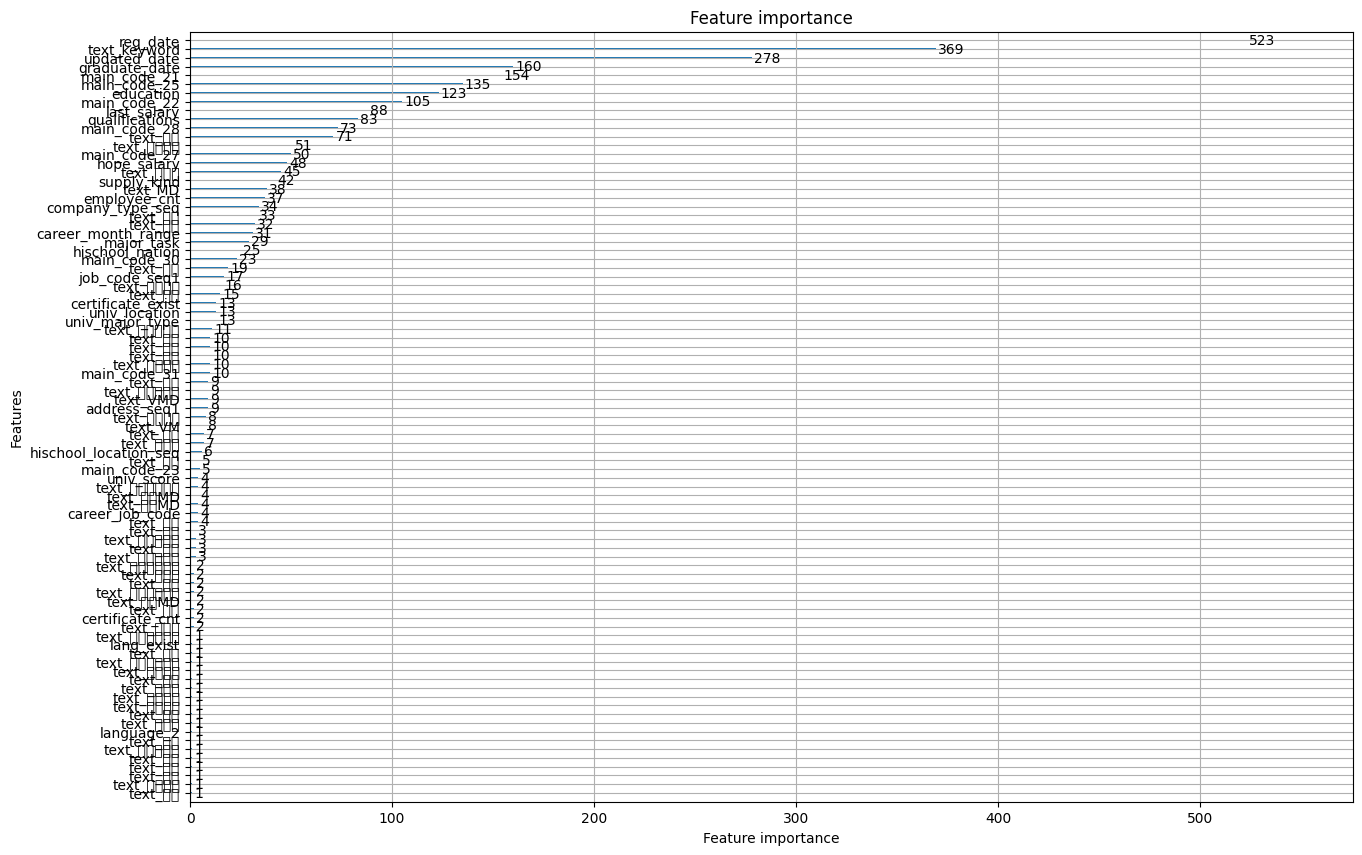

In [ ]:
fig, ax  = plt.subplots(figsize = (15,10))
plot_importance(model_V0,ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# confusion_matrix(실제값, 예측값)
# normalize="true" -> 확률값으로 변경!!
conf_mx = confusion_matrix(y_te, pred_te, normalize="true")
conf_mx

array([[0.61011554, 0.38988446],
       [0.22152794, 0.77847206]])

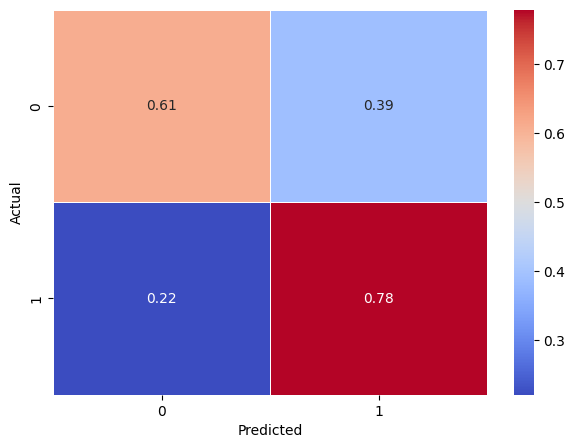

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

# annot=True -> 수치데이터 표시
# cmap -> 히트맵 컬러정의
# linewidth -> 선 두께
sns.heatmap(conf_mx, annot=True, cmap="coolwarm", linewidth=0.5)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 예측

In [ ]:
best_model = model_V0

In [ ]:
all_recommendations = []

for resume in tqdm(resume_pool):
#for resume in tqdm(['U00001', 'U00002','U00003', 'U00004', 'U00005']):
    # 2. 임시 데이터프레임 생성
    _df_temp = pd.DataFrame({'resume_seq': [resume] * len(recruitment)})

    # 3. 전체 공고 seq를 붙임
    _df_temp['recruitment_seq'] = list(recruitment_pool)
    _df_temp.head()

    # 4. 임시 데이터프레임에 feature들 merge. 이후 구직자, 공고 id 제거 및 모델 학습
    _df_train = pd.merge(_df_temp, merged_recruitment, on='recruitment_seq', how='left')
    _df_train = pd.merge(_df_train, merged_resume, on='resume_seq', how='left')
    _df_train_drop_col = ['recruitment_seq', 'resume_seq']
    _df_train.drop(_df_train_drop_col, axis = 1, inplace=True)

    # 5. 예측 확률 계산
    pred_proba = best_model.predict_proba(_df_train)[:,1]

    # 6. 임시 데이터프레임에 예측 확률 추가하고 상위로 정렬
    _df_temp['prediction'] = pred_proba
    _df_temp = _df_temp.sort_values(by='prediction', ascending=False)

    # 7. 현재 구직자의 이미 지원한 공고 가져오기
    already_applied_jobs = apply_train[apply_train['resume_seq'] == resume]['recruitment_seq'].values

    # 8. 임시 데이터프레임에서 이미 지원한 공고를 제거
    _df_temp = _df_temp[~_df_temp['recruitment_seq'].isin(already_applied_jobs)]

    # 상위 5개 추천 (이미 지원한 공고를 제외한 상위 5개)
    top_recommendations = _df_temp.head(5)

    # 결과 출력 또는 활용
    all_recommendations.append(top_recommendations)

final_recommendations = pd.concat(all_recommendations, ignore_index=True)
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]
final_recommendations = final_recommendations.sort_values(by='resume_seq')
final_recommendations


# Result 저장 (Submission)

In [ ]:
final_recommendations = final_recommendations[['resume_seq', 'recruitment_seq']]

In [ ]:
recall5(apply_train, final_recommendations)

In [ ]:
now = datetime.now() + timedelta(hours=9)
formatted_time = now.strftime("%Y%m%d_%H%M")

In [ ]:
final_recommendations.to_csv(args.default_path+ '/result/submission_'+formatted_time+'.csv', index=False)